In [1]:
# Enable automatic module reloading during development
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging
import yaml
from typing import Optional, Dict, List
from uuid import uuid4
import json
import hashlib
# from importlib import import_module, util
import importlib.util
import sys
from time import monotonic

In [3]:
try:
    # from .exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from .base_plugin import BasePlugin
    from .config_utils import validate_config
except ImportError:
#     # support jupyter developement
#     from exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from base_plugin import BasePlugin
    from config_utils import validate_config

In [4]:
# print(f"In base_plugin.py, __name__ = {__name__}")

In [5]:
logger = logging.getLogger(__name__)

In [6]:
def validate_path(func):
    """
    Decorator to validate that a value is a Path-like object or None.

    Converts strings to Path objects if necessary. Raises a TypeError if the value 
    is neither a string, a Path, nor None.

    Args:
        func (function): The setter function to wrap.

    Returns:
        function: A wrapped function that ensures the value is a Path or None.
    """
    def wrapper(self, value):
        path_name = func.__name__
        logger.debug(f"Validating {path_name}: {value} ({type(value)})")        
        if value is None:
            # Path can remain None (valid usage).
            return func(self, value)
        if isinstance(value, str):
            # Convert string to a Path
            value = Path(value)
        if not isinstance(value, Path):
            # If it's neither None nor Path, raise
            raise TypeError(
                f"{func.__name__} must be a Path object, string, or None. "
                f"Got '{type(value).__name__}'."
            )
        return func(self, value)
    return wrapper

In [40]:
class PluginManager:
    """
    Manages the loading, configuration, activation, and lifecycle of plugins.

    Supports plugin schema validation, plugin instantiation, update cycles,
    foreground switching, and caching of schema files.
    """
    ACTIVE = 'active'
    DORMANT = 'dormant'
    LOAD_FAILED = 'load_failed'
    CONFIG_FAILED = 'config_failed'
    CRASHED = 'crashed'
    PENDING = 'pending_validation'
    DEACTIVATED = 'deactivated'
    
    def __init__(
        self,
        plugin_path: Optional[Path] = None,
        config_path: Optional[Path] = None,
        config: Optional[dict] = None,
        base_schema_file: Optional[str] = None,
        plugin_schema_file: Optional[str] = None,
        plugin_param_filename: Optional[str] = 'plugin_param_schema.yaml',
        max_plugin_failures: int = 5,
    ):
        """
        Initialize the PluginManager with optional paths, config, and schema support.

        Args:
            plugin_path (Optional[Path]): Directory containing plugin subdirectories.
            config_path (Optional[Path]): Directory containing YAML schema/config files.
            config (Optional[dict]): Initial base configuration dictionary.
            base_schema_file (Optional[str]): Filename for the base schema to validate manager config.
            plugin_schema_file (Optional[str]): Filename for validating plugin configurations.
            plugin_param_filename (Optional[str]): Filename for per-plugin parameter schemas.
            max_plugin_failures (int): Maximum number of allowed consecutive plugin update failures.

        Example:
    
        # Load plugin configuration from a YAML file
        from library.config_utils import load_yaml_file
    
        pc_file = '/path/to/paperpi_plugins.yaml'
        plugin_config_data = load_yaml_file(pc_file)
    
        # Initialize the PluginManager
        manager = PluginManager(
            plugin_path='../plugins/',
            config_path='../config/',
            base_schema_file='../config/plugin_manager_schema.yaml',
            plugin_schema_file='plugin_schema.yaml'
        )
    
        # Set manager configuration
        manager.config = {
            'screen_mode': 'L',
            'resolution': (800, 600),
        }
    
        # Add plugins from loaded configuration
        manager.add_plugins(plugin_config_data['plugins'])

        """
        # Use property setters for path validations
        self.plugin_path = plugin_path
        self.config_path = config_path
        
        # Internal cache for previously loaded schemas
        self._schema_cache: Dict[str, dict] = {}
        
        # Prepare data structures
        self.configured_plugins: List[dict] = []
        self.active_plugins: List[dict] = []
        self.dormant_plugins: List[dict] = []        

        # keys to be dropped when comparing plugin configs
        self._transient_config_keys = ['uuid', 'plugin_status']
        
        # Store schema filename (may be None if no base schema is used)
        self.base_schema_file = base_schema_file
        self.plugin_schema_file = plugin_schema_file
        self.plugin_param_filename = plugin_param_filename

        # maximum number of times a plugin can fail before being deactivated
        self.max_plugin_failures = max_plugin_failures

        # If no config given, store an empty dict and defer validation.
        if config is None:
            logger.debug("No initial config provided. Using empty dictionary.")
            self._config = {}
        else:
            # Triggers the config.setter
            self.config = config.copy()

        # track the currently displayed plugin and start time
        self.foreground_plugin: Optional[BasePlugin] = None
        self.previous_foreground_plugin: Optional[BasePlugin] = None
        self.foreground_start_time: float = 0.0

        # index for cycling among active plugins
        self._active_index: int = 0

        # keep track of consecutive failures per plugin
        self.plugin_failures: Dict[str, int] = {}
    
        
        logger.info("PluginManager initialized.")

    # SCHEMA LOADING
    def load_schema(self, schema_file: str, cache: bool = True) -> dict:
        """
        Load and optionally cache a YAML schema file from `config_path` or from disk.
    
        Args:
            schema_file (str): The filename (or path) to the schema YAML.
            cache (bool): Whether to check and store the schema in the cache. Defaults to True.
    
        Returns:
            dict: Parsed schema data.
    
        Raises:
            FileNotFoundError: If the file is not found.
            ValueError: If the file is not valid YAML or is not a dict.
        """
        # Ensure schema_file is a Path object
        schema_path = Path(schema_file).resolve()
    
        # If caching is enabled, check for cached copy
        if cache and schema_path in self._schema_cache:
            logger.debug(f"Using cached schema for '{schema_path}'.")
            return self._schema_cache[schema_path]
    
        # Ensure the schema file exists
        if not schema_path.is_file():
            raise FileNotFoundError(f"Schema file not found: {schema_path}")
    
        # Load and parse the YAML
        try:
            with open(schema_path, "r") as f:
                data = yaml.safe_load(f)
        except yaml.YAMLError as e:
            raise ValueError(f"Failed to parse YAML for '{schema_path}': {e}")
    
        if not isinstance(data, dict):
            raise ValueError(f"Schema '{schema_path}' is not a valid dictionary.")
    
        # Cache the schema only if caching is enabled
        if cache:
            self._schema_cache[schema_path] = data
            logger.info(f"Schema '{schema_path}' cached successfully.")
    
        logger.info(f"Schema '{schema_path}' loaded successfully.")
        return data

    @staticmethod
    def validate_config(config: dict, schema: dict) -> dict:
        """
        Validate a configuration dictionary against a schema.

        Args:
            config (dict): The configuration dictionary to validate.
            schema (dict): The schema dictionary describing expected keys and rules.

        Returns:
            dict: A validated and merged configuration dictionary.

        Raises:
            ValueError: If the configuration does not match the schema.
        """
        # thin wrapper
        return validate_config(config, schema)
    # def validate_config(config: dict, schema: dict) -> dict:
    #     """
    #     Validate `config` against a dict-based schema, returning a new dict 
    #     that merges defaults and logs warnings for errors. Supports range validation.
    
    #     Args:
    #         config (dict): The configuration to be validated.
    #         schema (dict): Schema describing expected keys, types, allowed values, and ranges.
    
    #     Returns:
    #         dict: A *merged* config with defaults applied.
    
    #     Raises:
    #         ValueError: If validation fails for any required or type mismatch.
    #     """
    #     validated_config = {}
    #     errors = []
    
    #     for key, rules in schema.items():
    #         # Gather helpful info from the schema
    #         default_val = rules.get('default')
    #         required = rules.get('required', False)
    #         allowed = rules.get('allowed')
    #         value_range = rules.get('range', None)  # Range for numerical values
    #         description = rules.get('description', 'No description provided')
    
    #         # Convert string type to actual Python type
    #         try:
    #             expected_type = eval(rules.get('type', 'str'))
    #         except NameError:
    #             logger.warning(f"Unknown type in schema for '{key}'. Using 'str'.")
    #             expected_type = str
    
    #         # Handle missing required keys
    #         if key not in config:
    #             if required:
    #                 errors.append(
    #                     f"'{key}' configuration key is required, but missing. Reasonable value: {default_val}. Description: {description}"
    #                 )
    #             validated_config[key] = default_val
    #             continue
    
    #         # Key is present in user's config
    #         value = config[key]
    
    #         # Type validation
    #         if not isinstance(value, expected_type):
    #             errors.append(
    #                 f"'{key}' must be of type {expected_type}, got {type(value).__name__}."
    #             )
    #             validated_config[key] = default_val
    #             continue
    
    #         # Allowed value validation
    #         if allowed and value not in allowed:
    #             errors.append(
    #                 f"'{key}' must be one of {allowed}, got {value}."
    #             )
    #             validated_config[key] = default_val
    #             continue
    
    #         # Range validation for numerical types (int, float)
    #         if value_range and isinstance(value, (int, float)):
    #             min_val, max_val = value_range
    #             if not (min_val <= value <= max_val):
    #                 errors.append(
    #                     f"'{key}' must be within the range {value_range}, got {value}."
    #                 )
    #                 validated_config[key] = default_val
    #                 continue
    
    #         # Store valid values
    #         validated_config[key] = value
    
    #     # Log and keep extra keys that aren't in the schema
    #     for extra_key in config.keys() - schema.keys():
    #         logger.debug(f"Extra key '{extra_key}' in config not in schema. Keeping as-is.")
    #         validated_config[extra_key] = config[extra_key]
    
    #     # If errors occurred, raise collectively
    #     if errors:
    #         for e in errors:
    #             logger.warning(e)
    #         raise ValueError(f"Plugin manager configuration validation failed: {e}")
    
    #     logger.info("Configuration validated successfully.")
    #     return validated_config    

    
    # CONFIG PROPERTIES
    @property
    def config(self) -> dict:
        """
        Get the validated base configuration for the plugin manager.

        Returns:
            dict: The plugin manager's current configuration.
        """
        return self._config

    @config.setter
    def config(self, value: dict):
        """
        Set the plugin manager's base configuration, validating it against the base schema if available.

        Args:
            value (dict): The new configuration dictionary.

        Raises:
            TypeError: If the provided value is not a dictionary.
            Exception: If validation against the base schema fails.
        """
        if not isinstance(value, dict):
            raise TypeError("Config must be a dictionary.")

        if self.base_schema_file:
            try:
                schema = self.load_schema(self.base_schema_file)
                merged = self.validate_config(value, schema)
                self._config = merged
                logger.info("Manager config validated and applied.")
            except Exception as e:
                logger.error(f"Manager config validation failed: {e}")
                raise
        else:
            # No schema? Just store
            self._config = value
            logger.debug("No base schema. Using config as-is.")
    
    # PATHS and FILES
    @property
    def plugin_path(self) -> Optional[Path]:
        """
        Get the directory path where plugin subdirectories are located.

        Returns:
            Optional[Path]: The path to the plugin directory, or None if unset.
        """
        return getattr(self, "_plugin_path", None)

    @plugin_path.setter
    @validate_path
    def plugin_path(self, value):
        """
        Set the directory containing plugin subdirectories.

        Args:
            value (Union[str, Path, None]): Path to the plugin directory.

        Raises:
            TypeError: If the provided value is not a string, Path, or None.
        """
        self._plugin_path = value
        logger.debug(f"plugin_path set to {value}")

    @property
    def config_path(self) -> Optional[Path]:
        """
        Get the directory path where configuration and schema files are located.

        Returns:
            Optional[Path]: The path to the configuration directory, or None if unset.
        """
        return getattr(self, "_config_path", None)

    @config_path.setter
    @validate_path
    def config_path(self, value):
        """
        Set the directory path for configuration and schema files.

        Args:
            value (Union[str, Path, None]): Path to the configuration directory.

        Raises:
            TypeError: If the provided value is not a string, Path, or None.
        """
        self._config_path = value
        logger.debug(f"config_path set to {value}")

    @property
    def base_schema_file(self):
        """
        Get the base schema file path for manager configuration validation.

        Returns:
            Optional[Path]: Path to the base schema file, or None if not set.
        """
        return self._base_schema_file

    @base_schema_file.setter
    def base_schema_file(self, value):
        """
        Set the base schema file used for validating manager configuration.

        Args:
            value (Union[str, Path, None]): Filename of the base schema.

        Raises:
            FileNotFoundError: If the schema file does not exist at the expected location.
        """
        self._base_schema_file = value

        if not value or not self.config_path:
            return

        schema_path = Path(self.config_path) / value
        if not schema_path.is_file():
            raise FileNotFoundError(f"Base schema file '{value}' does not exist at {schema_path}")

        self._base_schema_file = schema_path

    @property
    def plugin_schema_file(self):
        """
        Get the plugin schema file path used for validating plugin configurations.

        Returns:
            Optional[Path]: Path to the plugin schema file, or None if not set.
        """
        return self._plugin_schema_file
    
    @plugin_schema_file.setter
    def plugin_schema_file(self, value):
        """
        Set the plugin schema file used for validating plugin configurations.

        Args:
            value (Union[str, Path, None]): Filename of the plugin schema.

        Raises:
            FileNotFoundError: If the plugin schema file does not exist and is not cached.
        """
        # Store the raw value initially
        self._plugin_schema_file = value
        
        # If no value or config_path is None, skip the path check
        if not value or not self.config_path:
            return
        
        schema_path = Path(self.config_path) / value
    
        # --- Check cache before file existence ---
        if value in self._schema_cache or schema_path in self._schema_cache:
            logger.debug(f"Using cached schema for '{schema_path}'. Skipping file check.")
            self._plugin_schema_file = schema_path
            return
        
        # Perform file existence check only if not cached
        if not schema_path.is_file():
            raise FileNotFoundError(f"Plugin schema file '{value}' does not exist at {schema_path}")
    
        # Store the fully resolved path
        self._plugin_schema_file = schema_path

    # PLUGIN LISTS, SETTERS AND ASSOCIATED FUNCTIONS
    @property
    def configured_plugins(self) -> List[dict]:
        """
        Get the list of plugin configurations currently set.

        Each entry should contain at minimum 'plugin' and 'plugin_config' keys.

        Returns:
            List[dict]: A list of plugin configuration dictionaries.
        """
        return self._configured_plugins

    @configured_plugins.setter
    def configured_plugins(self, plugins: List[dict]):
        """
        Set or replace the entire list of plugin configuration entries.

        Validates that each entry is a dictionary containing 'plugin' and 'base_config' keys.

        Args:
            plugins (List[dict]): List of plugin configuration dictionaries.

        Raises:
            TypeError: If the input is not a list of dictionaries.
            ValueError: If any dictionary is missing required keys.
        """
        if not plugins:
            logger.debug("No plugin configurations provided. Clearing list.")
            self._configured_plugins = []
            return

        if not isinstance(plugins, list):
            logger.error("configured_plugins must be a list.")
            raise TypeError("configured_plugins must be a list of dictionaries.")

        for plugin_dict in plugins:
            if not isinstance(plugin_dict, dict):
                logger.error("Invalid plugin format. Must be a dictionary.")
                raise TypeError("Each plugin must be a dictionary.")

            if 'plugin' not in plugin_dict or 'base_config' not in plugin_dict:
                logger.error("Missing 'plugin' or 'base_config' in plugin dict.")
                raise ValueError("Each plugin must have 'plugin' and 'base_config' keys.")

        logger.debug(f"Storing {len(plugins)} plugin configuration(s).")
        self._configured_plugins = plugins        
        
    # PLUGIN LIFE-CYCLE AND UPDATING
    def add_plugin(self, plugin_config: dict, force_duplicate: bool = False):
        """
        Validate and add a single plugin configuration to the configured plugins list.

        Args:
            plugin_config (dict): Dictionary containing plugin configuration data.
            force_duplicate (bool): If True, allows duplicate plugins with the same configuration.

        Returns:
            dict: The validated plugin configuration dictionary.

        Raises:
            FileNotFoundError: If the required plugin schema file does not exist.
            ValueError: If plugin validation fails.
        """
        if not self.plugin_schema_file:
            raise FileNotFoundError("Plugin schema is required, but is not set.")
    
        plugin_id = plugin_config.get('plugin')
        if not plugin_id:
            raise ValueError("Plugin configuration does not contain a valid 'plugin' identifier.")
    
        plugin_name = plugin_config.get('plugin_config', {}).get('name', 'UNSET NAME')
    
        logger.info(f"Adding plugin {plugin_name} of type {plugin_id}...")
    
        plugin_status = {
            'status': self.PENDING,
            'reason': 'Pending validation'
        }
    
        plugin_schema_file_path = self.plugin_schema_file
        try:
            plugin_schema = self.load_schema(plugin_schema_file_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"Base plugin schema file not found at {plugin_schema_file_path}")
    
        try:
            validated_plugin_config = self.validate_config(
                plugin_config.get('plugin_config', {}),
                plugin_schema
            )
        except ValueError:
            plugin_status['status'] = self.CONFIG_FAILED
            plugin_status['reason'] = 'Plugin config validation failed'
            logger.error(f"Plugin config validation failed for {plugin_name}")
            raise
    
        try:
            plugin_param_schema_file = self.plugin_path / plugin_id / self.plugin_param_filename
            plugin_param_schema = self.load_schema(plugin_param_schema_file, cache=False)
        except FileNotFoundError:
            logger.debug(f"Parameters schema file not found for plugin '{plugin_id}'. Assuming none required.")
            plugin_param_schema = {}
    
        plugin_params = plugin_config.get('plugin_params', {})
        try:
            validated_plugin_params = self.validate_config(plugin_params, plugin_param_schema)
        except ValueError:
            plugin_status['status'] = self.CONFIG_FAILED
            plugin_status['reason'] = 'Plugin params validation failed'
            logger.error(f"Plugin params validation failed for {plugin_id}")
            raise
    
        if validated_plugin_config.get('dormant', False):
            plugin_status.update(status=self.DORMANT, reason='Configuration validated (dormant)')
        else:
            plugin_status.update(status=self.ACTIVE, reason='Configuration validated')
    
        plugin_uuid = str(uuid4())[:8]
    
        final_config = {
            'plugin': plugin_id,
            'plugin_config': validated_plugin_config,
            'plugin_params': validated_plugin_params,
            'uuid': plugin_uuid,
            'plugin_status': plugin_status
        }
    
        # Duplicate check
        if not force_duplicate:
            new_signature = self.plugin_config_signature(final_config)
            for existing_plugin in self.configured_plugins:
                if self.plugin_config_signature(existing_plugin) == new_signature:
                    logger.info(
                        f"Duplicate detected: Plugin '{plugin_id}' already exists. Skipping addition."
                    )
                    return  # Early return to avoid adding duplicate
    
        self.configured_plugins.append(final_config)
        logger.info(
            f"Plugin '{plugin_id}' added with UUID={plugin_uuid} and status={plugin_status['status']}."
        )
        return final_config

    def add_plugins(self, plugin_configs: list[dict], force_duplicate: bool = False):
        """
        Add multiple plugin configurations at once.

        Each configuration is validated individually. Failed additions are logged separately.

        Args:
            plugin_configs (List[dict]): List of plugin configuration dictionaries.
            force_duplicate (bool): If True, allows adding duplicate configurations.

        Returns:
            dict: Summary dictionary with counts of added, failed, and duplicated plugins.
        """
        results = {
            'added': 0,
            'failed': 0,
            'duplicated': 0,
            'failures': [],
            'duplicate_config': [],           
        }
        logger.info(f"Processing {len(plugin_configs)} provided plugins.")
        for plugin_config in plugin_configs:
            plugin_id = plugin_config.get('plugin', 'UNKNOWN')
            try:
                returned_config = self.add_plugin(plugin_config, force_duplicate=force_duplicate)
                if returned_config:
                    results['added'] += 1
                else:
                    results['duplicated'] += 1
                    results['duplicate_config'].append({
                        'plugin': plugin_id,
                        'reason': 'Duplicate plugin with identical configuration found.'
                    })
            except (ValueError, FileNotFoundError) as e:
                # Mark the plugin as failed, but add to the list with status CONFIG_FAILED
                plugin_status = {
                    'status': self.CONFIG_FAILED,
                    'reason': str(e)
                }
                plugin_uuid = str(uuid4())[:8]
    
                failed_config = {
                    'plugin': plugin_id,
                    'plugin_config': plugin_config.get('plugin_config', {}),
                    'plugin_params': plugin_config.get('plugin_params', {}),
                    'uuid': plugin_uuid,
                    'plugin_status': plugin_status
                }
    
                self.configured_plugins.append(failed_config)
                results['failed'] += 1
                results['failures'].append({
                    'plugin': plugin_id,
                    'reason': str(e)
                })
    
                logger.warning(
                    f"Plugin '{plugin_id}' failed to add. Reason: {str(e)}"
                )
    
        logger.info(
            f"Plugin batch processing completed. Added: {results['added']}, "
            f"Failed: {results['failed']}."
        )
    
        return results
        
    def remove_plugin_config(self, uuid: str) -> bool:
        """
        Remove a plugin configuration by its UUID.

        Args:
            uuid (str): The UUID of the plugin to remove.

        Returns:
            bool: True if the plugin was removed, False if no matching UUID was found.
        """
        for i, plugin in enumerate(self.configured_plugins):
            if plugin.get('uuid') == uuid:
                removed_plugin = self.configured_plugins.pop(i)
                logger.info(f"Plugin '{removed_plugin['plugin']}' with UUID={uuid} removed.")
                return True
        
        logger.warning(f"No plugin with UUID={uuid} found.")
        return False
        
    def activate_plugin_by_uuid(self, uuid: str, status: str, reason = None) -> bool:
        """
        Activate a configured plugin by UUID and set its status as active or dormant.

        Args:
            uuid (str): The UUID of the plugin to activate.
            status (str): Desired status, either 'active' or 'dormant'.
            reason (Optional[str]): Reason for activation (default: 'Activated by UUID').

        Returns:
            bool: True if the plugin was successfully activated, False otherwise.
        """
        success = False
        if not status in (self.ACTIVE, self.DORMANT):
            logger.error(f"Valid status values for activated plugins are: {self.ACTIVE, self.DORMANT}")
            return False
        
        if not reason:
            reason = 'Activated by UUID'
        
        for config in self.configured_plugins:
            config_uuid = config.get('uuid')    
            if config_uuid == uuid:
                plugin_status = config.get('plugin_status', {})
                plugin_status['status'] = status
                plugin_status['reason'] = reason
                config['plugin_status'] = plugin_status
                
                if self.load_plugin(config):
                    success = True
        return success
                
    
    def deactivate_plugin_by_uuid(self, uuid: str, status: str = None, reason: str = None) -> bool:
        """
        Deactivate a plugin instance by UUID from the active or dormant lists.

        Args:
            uuid (str): The UUID of the plugin to deactivate.
            status (Optional[str]): Status to assign after deactivation (default: 'deactivated').
            reason (Optional[str]): Reason for deactivation.

        Returns:
            bool: True if the plugin was successfully deactivated, False otherwise.
        """
        success = False
        if not status:
            status = self.DEACTIVATED

        if not reason:
            reason = 'Plugin removed - no reason given'
        
        # Search and remove from active plugins
        for i, plugin in enumerate(self.active_plugins):
            if plugin.uuid == uuid:
                removed_plugin = self.active_plugins.pop(i)
                logger.info(f"Removed active plugin '{removed_plugin.name}' (UUID={uuid}).")
                success = True

        # Search and remove from dormant plugins
        for i, plugin in enumerate(self.dormant_plugins):
            if plugin.uuid == uuid:
                removed_plugin = self.dormant_plugins.pop(i)
                logger.info(f"Removed dormant plugin '{removed_plugin.name}' (UUID={uuid}).")
                success = True

        if success:
            for config in self.configured_plugins:
                if config.get('uuid') == uuid:
                    status = {'status': status,
                              'reason': reason}
                    config['plugin_status'] = status
                    break
        
        logger.warning(f"No active/dormant plugin with UUID={uuid} found.")
        return success

    def delete_plugin(self, uuid: str) -> bool:
        """
        Fully remove a plugin by UUID from active/dormant lists and configuration.

        Args:
            uuid (str): The UUID of the plugin to delete.

        Returns:
            bool: True if the plugin was removed from either the lists or config, False if not found.
        """
        removed_from_plugins = self.deactivate_plugin_by_uuid(uuid)
        removed_from_config = self.remove_plugin_config(uuid)

        if removed_from_plugins or removed_from_config:
            logger.info(f"Plugin with UUID={uuid} fully deleted.")
            return True
        
        logger.warning(f"Failed to delete plugin with UUID={uuid}. Not found in plugins or config.")
        return False
    
    def plugin_config_signature(self, plugin_config: dict) -> str:
        """
        Generate a consistent hash signature of a plugin configuration.

        Ignores transient fields like UUID and status that should not affect configuration equivalence.

        Args:
            plugin_config (dict): Plugin configuration dictionary.

        Returns:
            str: MD5 hash string representing the plugin configuration.
        """
        cfg = dict(plugin_config)
    
        # Ensure deep copy to avoid modifying the original
        cfg['plugin_config'] = dict(cfg.get('plugin_config', {}))
        cfg['plugin_params'] = dict(cfg.get('plugin_params', {}))
    
        # Remove transient fields
        for key in self._transient_config_keys:
            cfg.pop(key, None)
    
        # Convert to JSON for consistent ordering and hash it
        cfg_json = json.dumps(cfg, sort_keys=True)
        return hashlib.md5(cfg_json.encode('utf-8')).hexdigest()

    def load_plugin(self, entry: dict) -> Optional[BasePlugin]:
        """
        Load a single plugin from its configuration entry.

        Dynamically imports the plugin module, loads the layout, and constructs a BasePlugin instance.

        Args:
            entry (dict): A single plugin config entry from self.configured_plugins.

        Returns:
            Optional[BasePlugin]: Instantiated plugin if successful, None if loading fails.
        """
        plugin_status_info = entry.get("plugin_status", {})
        status = plugin_status_info.get("status", "").lower()
    
        # Only load if status is 'active' or 'dormant'
        if status not in (self.ACTIVE, self.DORMANT):
            logger.debug(f"Skipping plugin '{entry.get('plugin')}' with status='{status}'.")
            return None
    
        plugin_id  = entry.get("plugin", "unknown_plugin")
        plugin_uuid = entry.get("uuid")
        # Merge the plugin_params into plugin_config
        plugin_config = entry.get("plugin_config", {})
        plugin_params = entry.get("plugin_params", {})
        plugin_config["uuid"]   = plugin_uuid
        plugin_config["config"] = plugin_params
    
        # Ensure __init__.py exists
        plugin_dir  = self.plugin_path / plugin_id
        init_path   = plugin_dir / "__init__.py"
        if not init_path.is_file():
            reason = f"Plugin '{plugin_id}' does not contain __init__.py"
            logger.error(reason)
            entry["plugin_status"] = {"status": self.LOAD_FAILED, "reason": reason}
            return None
    
        # Dynamically load the plugin module from the filesystem
        try:
            spec = importlib.util.spec_from_file_location(plugin_id, str(init_path))
            module = importlib.util.module_from_spec(spec)
            sys.modules[plugin_id] = module
            spec.loader.exec_module(module)
        except Exception as e:
            reason = f"Failed to load plugin '{plugin_id}': {e}"
            logger.exception(reason)
            entry["plugin_status"] = {"status": self.LOAD_FAILED, "reason": reason}
            return None
    
        # Load the layout
        layout_name = plugin_config.get("layout_name")
        if not layout_name:
            reason = f"Plugin '{plugin_id}' missing 'layout_name'."
            logger.warning(reason)
            entry["plugin_status"] = {"status": self.LOAD_FAILED, "reason": reason}
            return None
    
        try:
            update_function = getattr(module.plugin, "update_function")
        except AttributeError as e:
            reason = f"update_function not found in {plugin_id}/plugin.py: {e}"
            logger.warning(reason)
            entry["plugin_status"] = {"status": self.LOAD_FAILED, "reason": reason}
            return None
    
        try:
            layout_obj = getattr(module.layout, layout_name)
            plugin_config["layout"] = layout_obj
        except AttributeError as e:
            reason = f"Layout '{layout_name}' not found in plugin '{plugin_id}': {e}"
            logger.warning(reason)
            entry["plugin_status"] = {"status": self.LOAD_FAILED, "reason": reason}
            return None
        except Exception as e:
            reason = f"Unexpected error accessing layout '{layout_name}' in '{plugin_id}': {e}"
            logger.exception(reason)
            entry["plugin_status"] = {"status": self.LOAD_FAILED, "reason": reason}
            return None
    
        # Check duplicates
        for p in self.active_plugins + self.dormant_plugins:
            if p.uuid == plugin_uuid:
                logger.warning("Plugin with duplicate UUID already configured. Will not add duplicate.")
                return None
    
        # Attempt to instantiate BasePlugin
        try:
            plugin_instance = BasePlugin(**plugin_config)
            plugin_instance.update_function = update_function
        except Exception as e:
            reason = f"Error creating BasePlugin for '{plugin_id}' (UUID={plugin_uuid}): {e}"
            logger.error(reason)
            entry["plugin_status"] = {"status": self.LOAD_FAILED, "reason": reason}
            return None
    
        # Success path: return the constructed plugin
        return plugin_instance


    def load_plugins(self) -> None:
        """
        Fresh load all configured active/dormant plugins based on configured entries.

        Clears existing active and dormant plugin references, then attempts to load each configured plugin.
        Updates plugin status depending on whether loading succeeds or fails.
        """
        # Clear old references
        self.active_plugins.clear()
        self.dormant_plugins.clear()
    
        for entry in self.configured_plugins:
            # Attempt to load a single plugin
            plugin_obj = self.load_plugin(entry)
            if plugin_obj is None:
                # The method sets plugin_status to LOAD_FAILED if it was needed
                continue
    
            # We have a plugin_obj. Decide if it’s active or dormant
            if plugin_obj.dormant:
                self.dormant_plugins.append(plugin_obj)
                entry["plugin_status"] = {
                    "status": self.DORMANT,
                    "reason": "Loaded as dormant",
                }
                logger.info(f"Loaded dormant plugin '{entry.get('plugin')}' (UUID={plugin_obj.uuid}).")
            else:
                self.active_plugins.append(plugin_obj)
                entry["plugin_status"] = {
                    "status": self.ACTIVE,
                    "reason": "Loaded as active",
                }
                logger.info(f"Loaded active plugin '{entry.get('plugin')}' (UUID={plugin_obj.uuid}).")
    
        logger.info(
            f"load_plugins complete: {len(self.active_plugins)} active, "
            f"{len(self.dormant_plugins)} dormant."
        )

    def _pick_next_active_plugin(self):
        """
        Select the next plugin from the active_plugins list in round-robin order.

        Resets the active index if out of bounds and updates the foreground plugin.
        """

        if not self.active_plugins:
            self.foreground_plugin = None
            self._active_index = 0
            return

        # handle out of range indexes by resetting to the 0th
        if self._active_index >= len(self.active_plugins):
            self._active_index = 0

        # use the _active_index to choose the next plugin
        chosen = self.active_plugins[self._active_index]
        self.foreground_plugin = chosen
        
        self.foreground_start_time = monotonic()

        logger.info(f"Foreground plugin set to '{chosen.name}, and will display for {chosen.duration}' seconds")

        # advance the index
        self._active_index = (self._active_index + 1) % len(self.active_plugins)


    def _safe_plugin_update(self, plugin, force=False):
        """
        Safely attempt to update a plugin, handling exceptions and failure thresholds.

        Args:
            plugin (BasePlugin): The plugin instance to update.
            force (bool): Whether to force the update.

        Returns:
            dict: Update status result from the plugin.
        """
        success = {}
        uuid = plugin.uuid
        name = plugin.name
        logger.debug(f"Safe-updating plugin {name}, UUID: {uuid}")
        try:
            success = plugin.update(force)
            if success:
                # reset failure count
                self.plugin_failures[uuid] = 0 
                return success
            else:
                # Update failed, but no exception
                self.plugin_failures[uuid] = self.plugin_failures.get(uuid, 0) + 1
                logger.warning(f"{plugin.name}, uuid: {plugin.uuid} failed to update."
                               f"consecutive failures={self.plugin_failures[uuid]}")
        except Exception as e:
            self.plugin_failure[uuid] = self.plugin_failures.get(uuid, 0) + 1
            logger.error(f"Exception during {plugin.name}, uuid: {plugin.uuid} update: {e}", exc_info=True)

        # Check failure threshold
        if self.plugin_failures[uuid] >= self.max_plugin_failures:
            logger.warning(f"{plugin.name}, uuid: {plugin.uuid} removed after {self.max_plugin_failures} consecutive failures. ")
            # remove plugin from active list and set status as CRASHED in config
            reason = F"Plugin {name}, UUID: {uuid} failed to update {self.max_plugin_failures}"
            self.deactivate_plugin_by_uuid(uuid, status=self.CRASHED, reason=reason)
            logger.warning(reason)
        # return False
        return success

    def list_plugins(self):
        """
        List all plugins grouped by their status.

        Returns:
            dict: A dictionary categorizing plugins by 'active', 'dormant', or 'other' statuses,
                  with each entry containing plugin details like name, UUID, and status.
        """
        plugin_dict ={}
        for p in self.configured_plugins:
            plugin_status = p.get('plugin_status', {})
            status = plugin_status.get('status')
            plugin_id = p.get('plugin', 'unknown')
            name = p.get('plugin_config', {}).get('name')
            uuid = p.get('uuid', 'no uuid set')
            if status in ('dormant', 'active'):
                tag = status
            else:
                tag = 'other'
            if not plugin_dict.get(tag, None):
                plugin_dict[tag] = {}
            plugin_dict[tag][uuid] = {'plugin': plugin_id,
                                'name': name,
                                'uuid': uuid,
                                'plugin_status': plugin_status}
            
        return plugin_dict
        
    def update_cycle(self, force_update: bool = False, force_cycle: bool = False) -> None:
        """
        Update and manage the foreground and dormant plugins during a display cycle.

        Forces updates or cycling when requested, handles plugin failures, and foreground switches.

        Args:
            force_update (bool): Force updates for all plugins, even if not ready.
            force_cycle (bool): Force switching to the next plugin regardless of display timer.
        """
        logger.info(f"Starting plugin update cycle - force_update: {force_update}, force_cycle: {force_cycle}")
        update_success = False

        # ensure there is a foreground plugin
        if not self.foreground_plugin:
            logger.debug("No foreground plugin found. Attempting to pick one from active plugins.")
            self._pick_next_active_plugin()
            self.previous_foreground_plugin = self.foreground_plugin
            if not self.foreground_plugin:
                logger.warning("No active plugins are available to foreground!")
                return

        # store the last successful foreground plugin as a fallback
        self.previous_foreground_plugin = self.foreground_plugin

        
        # attempt to update foreground plugins
        if self.foreground_plugin.ready_for_update or force_update:
            logger.info(f"Updating foreground plugin {self.foreground_plugin.name}, UUID: {self.foreground_plugin.uuid}")
            update_success = self._safe_plugin_update(self.foreground_plugin, force_update)
            if not update_success:
                logger.error(f"Foreground plugin '{self.foreground_plugin}' update failed.")
        else:
           logger.debug(f"Foreground plugin '{self.foreground_plugin.name}' not ready for update. "
                       f"Time to refresh: {self.foreground_plugin.time_to_refresh:.2f} seconds.")

        # check display timer and cycle if expired
        display_timer = monotonic() - self.foreground_start_time
        if display_timer >= self.foreground_plugin.duration or force_cycle:
            logger.info(f"Display ended for '{self.foreground_plugin.name}' due to "
                        f"{'forced cycle' if force_cycle else 'timer expiration'}.")
            self._pick_next_active_plugin()
            if self.foreground_plugin:
                self._safe_plugin_update(self.foreground_plugin)
        else:
            remaining = display_timer - self.foreground_plugin.duration
            logger.info(f"Foreground plugin '{self.foreground_plugin.name}' displaying for {remaining:.2f} more seconds.")

        # poll dormant plugins for updates and check for high-priority signals
        for plugin in self.dormant_plugins:
            if plugin.ready_for_update or force_update:
                logger.debug(f"Updating dormant plugin: {plugin.name}")
                update_success = self._safe_plugin_update(plugin, force_update)

                if update_success and plugin.high_priority:
                    logger.info(f"Dormant plugin '{plugin.name}', UUID: {plugin.uuid} signaled high priority."
                                f"Replacing foreground plugin '{self.foreground_plugin.name}' with '{plugin.name}'")
                    self.foreground_plugin = plugin
                    self.foreground_start_time = monotonic()
                    plugin.high_priority = False
                else:
                    logger.debug(f"Dormant plugin '{plugin.name}' updated but did not signal high priority.")

        # handle failure fallback to previous plugin
        if not update_success:
            logger.error(f"Update cycle failed, falling back to previous foreground plugin: "
                         f"{self.previous_foreground_plugin.name if self.previous_foreground_plugin else 'None'}.")
            if self.previous_foreground_plugin:
                self.foreground_plugin = self.previous_foreground_plugin

        logger.info("Completed plugin update cycle.")

    def clear_cache(self, force: bool = False):
        """
        Clear or expire cached documents for all active and dormant plugins.

        Args:
            force (bool): If True, forcibly clear all cached documents; otherwise, only expire old files.
        """
        for plugin in self.active_plugins + self.dormant_plugins:
            logger.info(f"{'Forcing cache clear' if force else 'Expiring old files'} for {plugin.name}...")
            plugin.clear_cache(all_files=force)

2025-04-27 12:56:56,635 - __main__ - DEBUG - foo
2025-04-27 12:56:56,640 - library.config_utils - INFO - Reading yaml file at /home/pi/.config/com.txoof.paperpi/paperpi_plugins.yaml
2025-04-27 12:56:56,652 - library.config_utils - INFO - YAML file '/home/pi/.config/com.txoof.paperpi/paperpi_plugins.yaml' loaded successfully.
2025-04-27 12:56:56,654 - __main__ - DEBUG - Validating plugin_path: ../plugins/ (<class 'str'>)
2025-04-27 12:56:56,657 - __main__ - DEBUG - plugin_path set to ../plugins
2025-04-27 12:56:56,660 - __main__ - DEBUG - Validating config_path: ../config/ (<class 'str'>)
2025-04-27 12:56:56,662 - __main__ - DEBUG - config_path set to ../config
2025-04-27 12:56:56,665 - __main__ - DEBUG - No plugin configurations provided. Clearing list.
2025-04-27 12:56:56,671 - __main__ - DEBUG - No initial config provided. Using empty dictionary.
2025-04-27 12:56:56,673 - __main__ - INFO - PluginManager initialized.
2025-04-27 12:56:56,690 - __main__ - INFO - Schema '/home/pi/src/Pap

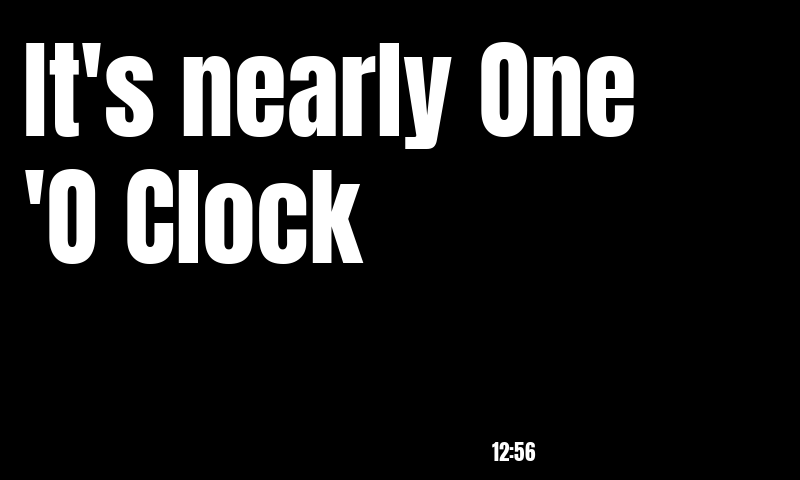

In [69]:
# # Configure logging for standalone module testing
# import logging

# # Configure the root logger globally
# logging.basicConfig(
#     level=logging.DEBUG,  # Set root level
#     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
# )

# logger = logging.getLogger(__name__)
# logger.debug('foo')

# import sys
# from pathlib import Path

# # Manually point to your project root
# PROJECT_ROOT = Path.cwd().parent  # adjust this if needed
# sys.path.append(str(PROJECT_ROOT))

# from library.config_utils import load_yaml_file

# pc_file = '/home/pi/.config/com.txoof.paperpi/paperpi_plugins.yaml'
# pc = load_yaml_file(pc_file)

# pc

# p = PluginManager(plugin_path='../plugins/',
#                   config_path='../config/',
#                   base_schema_file='../config/plugin_manager_schema.yaml',
#                   plugin_schema_file='plugin_schema.yaml'
#                  )

# pc

# p.config = {
#     'screen_mode': 'L',
#     'resolution': (800, 600),
# }
# p.add_plugins(pc['plugins'])

# p.list_plugins()

# p.config

# p.configured_plugins

# p.load_plugins()

# p.update_cycle()

# p.foreground_plugin.update(force=True)
# p.foreground_plugin.image
